# Transfer Learning with Pre-trained Models on CIFAR-100

## Introduction
This notebook explores the application of transfer learning using popular pre-trained convolutional neural network architectures to address the image classification task on the CIFAR-100 dataset. Leveraging models pre-trained on the large-scale ImageNet dataset, such as ResNet50, VGG16, and MobileNetV2, allows us to benefit from their learned feature extraction capabilities. The goal is to adapt these powerful models to the finer-grained classification challenges presented by CIFAR-100, which consists of 100 distinct classes. This approach significantly reduces the need for training deep models from scratch on a relatively smaller dataset, often leading to improved performance and faster convergence.

## Project Flow

1.  **Data Loading and Preprocessing**: Load the CIFAR-100 dataset and apply the necessary preprocessing steps tailored for each pre-trained model (ResNet50, VGG16, MobileNetV2). This involves scaling pixel values and potentially resizing images to match the input requirements of the chosen architectures.

2.  **Model Preparation**:
    *   Load pre-trained models (ResNet50, VGG16, MobileNetV2) without their top classification layers.
    *   Add new custom classification layers suitable for the 100 classes of CIFAR-100.
    *   Freeze the layers of the pre-trained base models to retain the learned features during initial training.
    *   Compile the models with an appropriate optimizer, loss function, and metrics.

3.  **Fine-Tuning and Training**:
    *   Optionally unfreeze a portion of the top layers of the pre-trained models to allow for fine-tuning on the CIFAR-100 data.
    *   Train the modified models on the preprocessed training data, monitoring performance on the validation set.

4.  **Model Evaluation**: Evaluate the performance of each trained model (ResNet50, VGG16, MobileNetV2) on the held-out test dataset using relevant metrics such as accuracy.

5. **Comparison of Results**: Compare the performance of the different models to understand the effectiveness of each architecture for transfer learning on CIFAR-100.

## 1. Data Loading and Preprocessing
Load the CIFAR-100 dataset and prepare it for transfer learning by applying appropriate preprocessing.

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100

from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2


(X_train, y_train), (X_test, y_test) = cifar100.load_data()

X_train_resnet50 = preprocess_resnet50(X_train)
X_test_resnet50  = preprocess_resnet50(X_test)

X_train_vgg16 = preprocess_vgg16(X_train)
X_test_vgg16  = preprocess_vgg16(X_test)

X_train_mobilenetv2 = preprocess_mobilenetv2(X_train)
X_test_mobilenetv2  = preprocess_mobilenetv2(X_test)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


## 2. Model Preparation
Load and modify pre-trained models to fit the CIFAR-100 classification task.

### 2.1 Using ResNet50

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without the top layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x) # output layer

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

model_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 2.2 Using VGG16

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 2.3 Using MobileNetV2

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained MobileNetV2 model without the top layer
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

model_mobilenetv2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/tmp/ipython-input-3794676327.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 3. Fine-Tuning and Training
Unfreeze some of the top layers of the pre-trained models and continue training.

In [6]:
epochs = 3

print(len(model_resnet50.layers))
print(len(model_vgg16.layers))
print(len(model_mobilenetv2.layers))


# Fine-tuning ResNet50
for layer in model_resnet50.layers[:-30]:
    layer.trainable = False

for layer in model_resnet50.layers[-30:]:
    layer.trainable = True

history_resnet50 = model_resnet50.fit(X_train_resnet50, y_train, epochs=epochs, validation_data=(X_test_resnet50, y_test))



# Fine-tuning VGG16
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False

for layer in model_vgg16.layers[-5:]:
    layer.trainable = True

history_vgg16 = model_vgg16.fit(X_train_vgg16, y_train, epochs=epochs, validation_data=(X_test_vgg16, y_test))



# Fine-tuning MobileNetV2
for layer in model_mobilenetv2.layers[:-40]:
    layer.trainable = False

for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True

history_mobilenetv2 = model_mobilenetv2.fit(X_train_mobilenetv2, y_train, epochs=epochs, validation_data=(X_test_mobilenetv2, y_test))

178
22
157
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step - accuracy: 0.2797 - loss: 3.0743 - val_accuracy: 0.3934 - val_loss: 2.3786
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.4676 - loss: 1.9708 - val_accuracy: 0.4334 - val_loss: 2.2244
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5606 - loss: 1.5648 - val_accuracy: 0.4454 - val_loss: 2.2818
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.0833 - loss: 6.6256 - val_accuracy: 0.1120 - val_loss: 3.6798
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.1234 - loss: 3.5699 - val_accuracy: 0.1559 - val_loss: 3.3529
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.1689 - loss: 3.2089 - val_accuracy: 0.1997 - val_loss: 3.1037
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 21ms/step - accuracy: 0.1331 - loss: 3.8113 - val_accuracy: 0.0761 - val_loss: 4.9812
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.2667

## 4. Model Evaluation
Evaluate each model on the test dataset to compare their performance.

In [7]:
acc_resnet50    = model_resnet50.evaluate(X_test_resnet50, y_test)[1]
acc_vgg16       = model_vgg16.evaluate(X_test_vgg16, y_test)[1]
acc_mobilenetv2 = model_mobilenetv2.evaluate(X_test_mobilenetv2, y_test)[1]

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4464 - loss: 2.2907
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1942 - loss: 3.0968
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2819 - loss: 3.0284
ResNet50 Accuracy: 0.45
VGG16 Accuracy: 0.20
MobileNetV2 Accuracy: 0.28


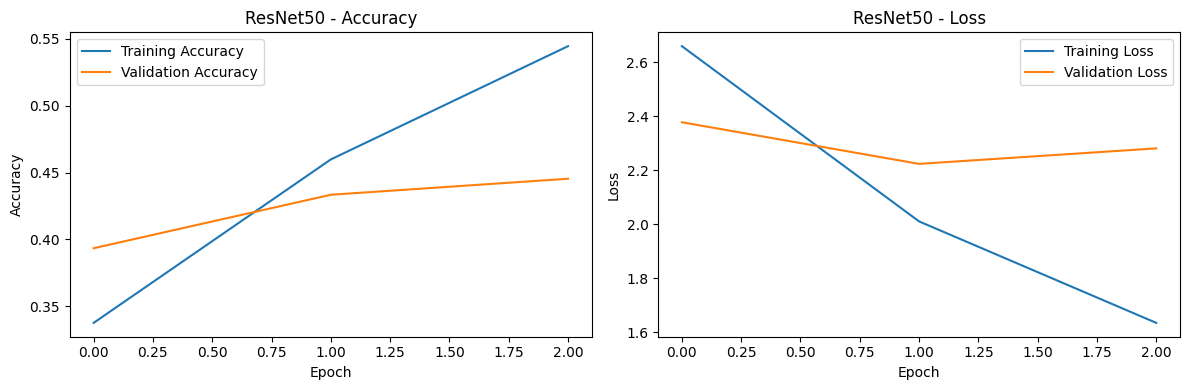

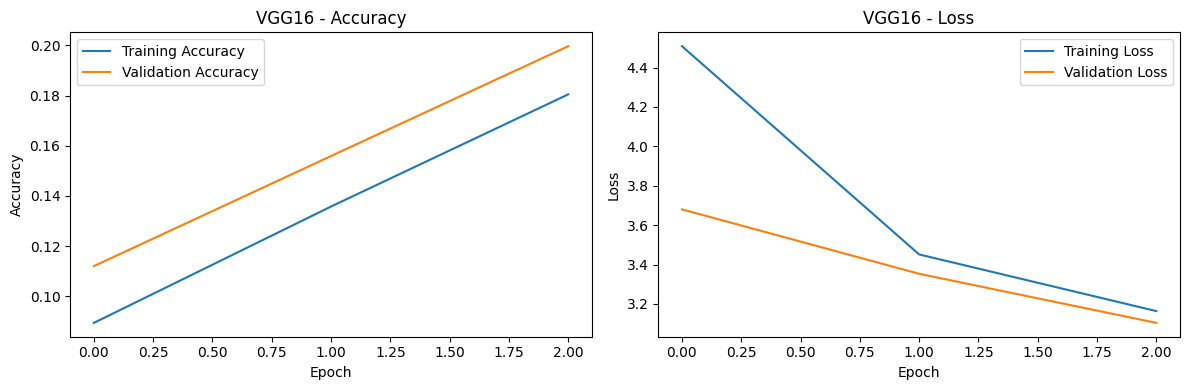

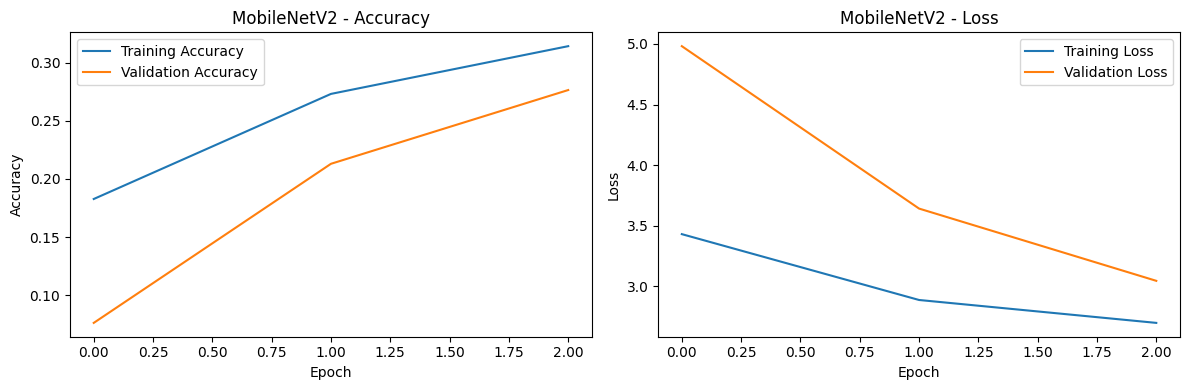

In [8]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet50, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenetv2, 'MobileNetV2')

In [9]:
# Save the models
model_resnet50.save('resnet50_cifar100.h5')
model_vgg16.save('vgg16_cifar100.h5')
model_mobilenetv2.save('mobilenetv2_cifar100.h5')

## Project Summary

*   **Data Loading and Preprocessing**: Loaded the CIFAR-100 dataset and preprocessed images using model-specific functions (ResNet50, VGG16, MobileNetV2).
*   **Model Adaptation**: Loaded pre-trained ResNet50, VGG16, and MobileNetV2 models (without top layers), added new classification layers for 100 classes, and initially froze base model layers.
*   **Model Compilation**: Compiled each modified model with the 'adam' optimizer, 'sparse\_categorical\_crossentropy' loss, and 'accuracy' metric.
*   **Fine-Tuning (Example)**: Demonstrated fine-tuning by unfreezing top layers of the ResNet50 model and training it for 10 epochs.
*   **Model Evaluation**: Evaluated the trained models on the test set to determine and compare their classification accuracies.

## Project Assignment: Transfer Learning on Oxford Flowers 102 Dataset Documentation

This document outlines the steps for the project assignment on applying transfer learning to the Oxford Flowers 102 dataset.

**Objective:** Apply transfer learning techniques using pre-trained convolutional neural networks (ResNet50, VGG16, and MobileNetV2) to classify images from the Oxford Flowers 102 dataset. Compare the performance of the different models on this dataset.

**Dataset:** Oxford Flowers 102 - A dataset of 102 categories of flowers. You will load this dataset using TensorFlow Datasets.

**Assignment Steps:**

1.  **Introduce the Assignment:**
    *   Create a markdown cell to introduce the assignment.
    *   Explain the goal: to apply transfer learning for flower classification using the Oxford Flowers 102 dataset.
    *   Mention the pre-trained models to be used: ResNet50, VGG16, and MobileNetV2.
    *   Briefly describe the Oxford Flowers 102 dataset.

2.  **Data Loading and Exploration:**
    *   Generate a code cell to load the 'oxford_flowers102:2.1.1' dataset using `tfds.load()`. (Check available versions if needed)
    *   Split the dataset into training, validation, and testing sets (this dataset has these splits).
    *   Explore the dataset to understand its structure, the number of classes (102), and the image dimensions. You can display some sample images and their labels.

3.  **Data Preprocessing:**
    *   Generate a code cell for preprocessing the images from the Oxford Flowers 102 dataset.
    *   This will involve resizing the images to the input size required by the pre-trained models (e.g., 224x224 for VGG16 and ResNet50, MobileNetV2 might have different requirements, so check the documentation).
    *   Apply the model-specific preprocessing functions (e.g., `tf.keras.applications.resnet50.preprocess_input`) to normalize the pixel values.
    *   Apply one-hot encoding to the labels.
    *   Batch and prefetch the datasets for efficient training.

4.  **Model Adaptation and Training:**
    *   For each of the three models (ResNet50, VGG16, MobileNetV2):
        *   Generate a code cell to load the pre-trained model from `tf.keras.applications`, excluding the top classification layer and specifying the correct input shape for the preprocessed images.
        *   Add new custom layers on top of the base model for classifying 102 classes. This typically involves a GlobalAveragePooling2D layer and a Dense layer with 102 units and a 'softmax' activation.
        *   Freeze the layers of the pre-trained base model.
        *   Compile the model with an appropriate optimizer (e.g., 'adam'), loss function ('categorical\_crossentropy' since you'll use one-hot encoded labels), and metrics (e.g., 'accuracy').
        *   Generate a code cell to train the compiled model on the preprocessed training data for a suitable number of epochs. Use the validation data to monitor performance during training. Consider using callbacks like ModelCheckpoint and EarlyStopping.
        *   Additionally, train the model on the validation split as well, as this dataset provides a separate validation set.
        *   Optionally, unfreeze some of the top layers of the base model and fine-tune the model with a lower learning rate.

5.  **Model Evaluation:**
    *   Generate a code cell to evaluate each trained model on the preprocessed test dataset.
    *   Print the loss and accuracy for each model.

6.  **Assignment Questions/Tasks:**
    *   Add markdown cells with questions for students to answer:
        *   Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?
        *   Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?
        *   Discuss the effect of transfer learning on this dataset.
        *   Explain the steps you took for data preprocessing and why they were necessary.
        *   Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
        *   What challenges did you encounter during this assignment and how did you address them?
    *   Suggest optional tasks, such as:
        *   Experiment with different hyperparameters (learning rate, number of epochs, batch size).
        *   Implement data augmentation techniques.
        *   Try fine-tuning different numbers of layers.
        *   Visualize sample predictions and analyze misclassifications.

7.  **Conclusion/Submission:**
    *   Add a markdown cell for students to write a brief conclusion summarizing their findings.
    *   Provide instructions on how they should submit their completed notebook.

Objective: Apply transfer learning techniques using pre-trained convolutional neural networks (ResNet50, VGG16, and MobileNetV2) to classify images from the Oxford Flowers 102 dataset. Compare the performance of the different models on this dataset.

Dataset: Oxford Flowers 102 - A dataset of 102 categories of flowers. You will load this dataset using TensorFlow Datasets.

# Data Loading and Exploration

In [10]:
import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.BG2XNC_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.BG2XNC_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.BG2XNC_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see

In [11]:
for image, label in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (500, 667, 3)
Label: 72


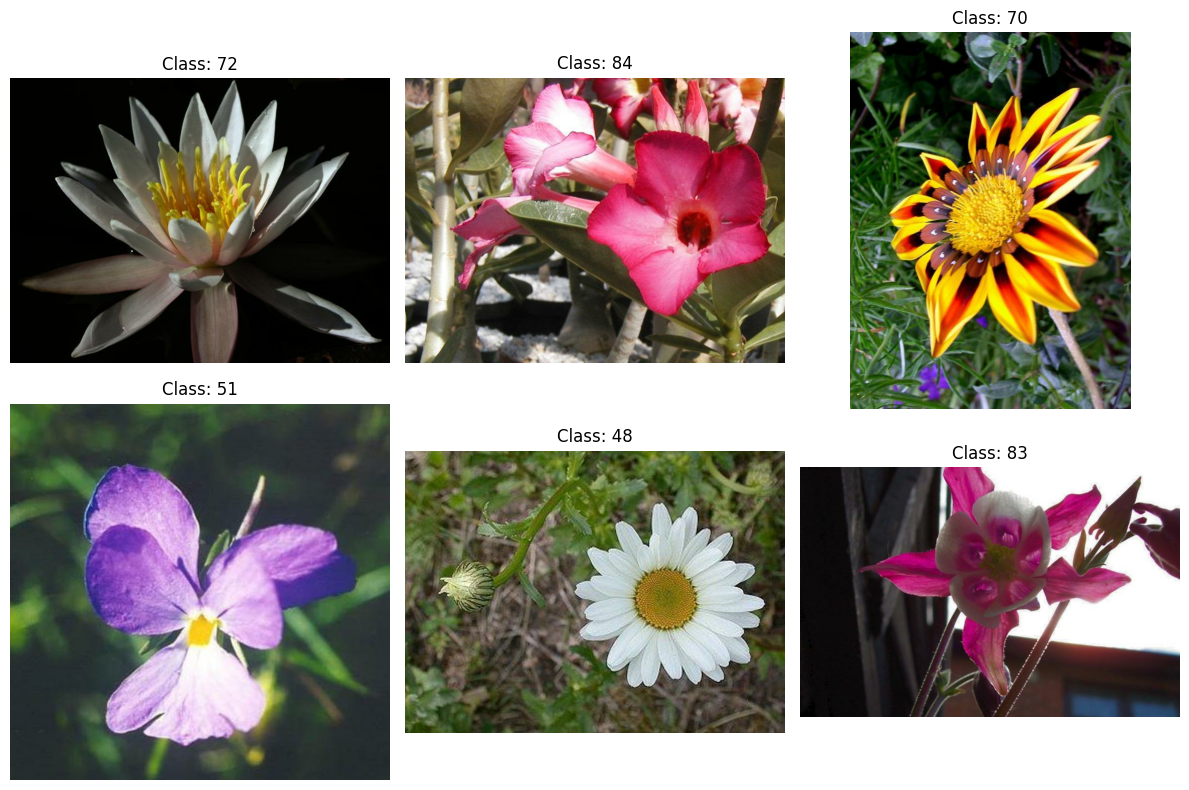

In [12]:
plt.figure(figsize=(12,8))

for i, (image, label) in enumerate(train_dataset.take(6)):
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title(f"Class: {label.numpy()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Sample images from the Training Dataset:


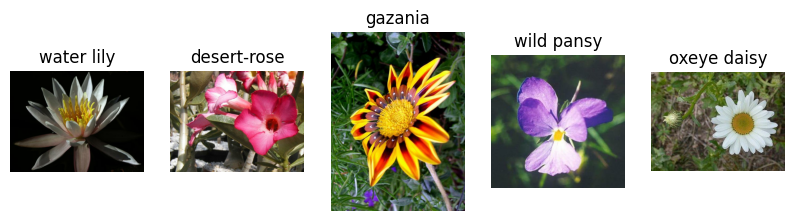

In [14]:
# Get the human-readable class names
class_names = info.features['label'].names

# Function to display sample images
def display_samples(dataset, num_samples=5):
    plt.figure(figsize=(10, 10))

    for i, (image, label) in enumerate(dataset.take(num_samples)):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[label.numpy()])
        plt.axis("off")
    plt.show()

# Display 5 sample images from the training dataset
print("Sample images from the Training Dataset:")
display_samples(train_dataset)

# Data Preprocessing

In [15]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = info.features['label'].num_classes

# Preprocessing Functions for each model

def create_preprocessor(preprocess_fn):
    """A factory function to create a specific preprocessor."""
    def preprocess(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = preprocess_fn(image)  # Apply model-specific normalization
        label = tf.one_hot(label, NUM_CLASSES)
        return image, label
    return preprocess

# Create Data Pipelines

def create_dataset_pipeline(dataset, preprocess_function, is_training=True):
    """Creates a complete, efficient data pipeline."""
    pipeline = dataset.map(preprocess_function, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        pipeline = pipeline.shuffle(buffer_size=1000)
    pipeline = pipeline.batch(BATCH_SIZE)
    pipeline = pipeline.prefetch(buffer_size=tf.data.AUTOTUNE)
    return pipeline

# ResNet50 Data Pipelines
preprocess_resnet = create_preprocessor(preprocess_resnet50)
train_ds_resnet = create_dataset_pipeline(train_dataset, preprocess_resnet)
val_ds_resnet = create_dataset_pipeline(validation_dataset, preprocess_resnet, is_training=False)
test_ds_resnet = create_dataset_pipeline(test_dataset, preprocess_resnet, is_training=False)

# VGG16 Data Pipelines
preprocess_vgg16 = create_preprocessor(preprocess_vgg16)
train_ds_vgg16 = create_dataset_pipeline(train_dataset, preprocess_vgg16)
val_ds_vgg16 = create_dataset_pipeline(validation_dataset, preprocess_vgg16, is_training=False)
test_ds_vgg16 = create_dataset_pipeline(test_dataset, preprocess_vgg16, is_training=False)

# MobileNetV2 Data Pipelines
preprocess_mobilenet = create_preprocessor(preprocess_mobilenetv2)
train_ds_mobilenet = create_dataset_pipeline(train_dataset, preprocess_mobilenet)
val_ds_mobilenet = create_dataset_pipeline(validation_dataset, preprocess_mobilenet, is_training=False)
test_ds_mobilenet = create_dataset_pipeline(test_dataset, preprocess_mobilenet, is_training=False)

print("Data preprocessing pipelines created for ResNet50, VGG16, and MobileNetV2.")

Data preprocessing pipelines created for ResNet50, VGG16, and MobileNetV2.


# Resnet50 Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

IMG_SIZE = 224
NUM_CLASSES = 102

# 1. Load the pre-trained ResNet50 model
base_model_resnet = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                             include_top=False,
                             weights='imagenet')

# 2. Freeze the base model
base_model_resnet.trainable = False

# 3. Create the new model on top
model_resnet = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model_resnet,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')
])

# 4. Compile the model
model_resnet.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Display the model architecture
model_resnet.summary()

# 5. Train the model
print("\n--- Training ResNet50 Model ---")
history_resnet = model_resnet.fit(train_ds_resnet,
                                  epochs=10,
                                  validation_data=val_ds_resnet)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 102)            │       208,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,796,710 (90.78 MB)

 Trainable params: 208,998 (816.40 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Training ResNet50 Model ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 556ms/step - accuracy: 0.0614 - loss: 4.8275 - val_accuracy: 0.4676 - val_loss: 2.5792
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.6953 - loss: 1.6898 - val_accuracy: 0.7078 - val_loss: 1.4929
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.9401 - loss: 0.7099 - val_accuracy: 0.7706 - val_loss: 1.1355
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.9776 - loss: 0.3641 - val_accuracy: 0.8235 - val_loss: 0.9486
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.9957 - loss: 0.2164 - val_accuracy: 0.8422 - val_loss: 0.8434
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 1.0000 - loss: 0.1420 - val_accuracy: 0.8451 - val_loss: 0.7887
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 1.0000 - loss: 0.1148 - val_accuracy: 0.8588 - val_loss: 0.7480
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 1.

# VGG16 Model

In [18]:
IMG_SIZE = 224
NUM_CLASSES = 102

# 1. Load the pre-trained VGG16 model
base_model_vgg16 = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

# 2. Freeze the base model
base_model_vgg16.trainable = False

# 3. Create the new model on top
model_vgg16 = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model_vgg16,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')
])

# 4. Compile the model
model_vgg16.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model architecture
model_vgg16.summary()

# 5. Train the model
print("\n--- Training VGG16 Model ---")
history_vgg16 = model_vgg16.fit(train_ds_vgg16,
                                epochs=10,
                                validation_data=val_ds_vgg16)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 102)            │        52,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,767,014 (56.33 MB)

 Trainable params: 52,326 (204.40 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


--- Training VGG16 Model ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 786ms/step - accuracy: 0.0228 - loss: 12.0631 - val_accuracy: 0.0422 - val_loss: 7.4344
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 351ms/step - accuracy: 0.0994 - loss: 6.2058 - val_accuracy: 0.1539 - val_loss: 4.7875
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 352ms/step - accuracy: 0.3339 - loss: 3.1825 - val_accuracy: 0.2961 - val_loss: 3.3961
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 349ms/step - accuracy: 0.5507 - loss: 1.8422 - val_accuracy: 0.3941 - val_loss: 2.7265
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - accuracy: 0.7132 - loss: 1.1289 - val_accuracy: 0.4569 - val_loss: 2.2937
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.8236 - loss: 0.7550 - val_accuracy: 0.4922 - val_loss: 2.0756
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 365ms/step - accuracy: 0.9062 - loss: 0.4690 - val_accuracy: 0.5275 - val_loss: 1.9117
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 351ms/step - accuracy: 0

# MobileNetv2 Model

In [19]:
IMG_SIZE = 224
NUM_CLASSES = 102

# 1. Load the pre-trained MobileNetV2 model
base_model_mobilenet = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                   include_top=False,
                                   weights='imagenet')

# 2. Freeze the base model
base_model_mobilenet.trainable = False

# 3. Create the new model on top
model_mobilenet = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model_mobilenet,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')
])

# 4. Compile the model
model_mobilenet.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Display the model architecture
model_mobilenet.summary()

# 5. Train the model
print("\n--- Training MobileNetV2 Model ---")
history_mobilenet = model_mobilenet.fit(train_ds_mobilenet,
                                        epochs=10,
                                        validation_data=val_ds_mobilenet)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 102)            │       130,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Training MobileNetV2 Model ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 675ms/step - accuracy: 0.0496 - loss: 4.7445 - val_accuracy: 0.3980 - val_loss: 3.1115
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.6361 - loss: 2.3672 - val_accuracy: 0.6343 - val_loss: 2.0187
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.8760 - loss: 1.1942 - val_accuracy: 0.7137 - val_loss: 1.5479
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9575 - loss: 0.7473 - val_accuracy: 0.7549 - val_loss: 1.2976
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9766 - loss: 0.4790 - val_accuracy: 0.7716 - val_loss: 1.1667
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9887 - loss: 0.3352 - val_accuracy: 0.7765 - val_loss: 1.0725
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9970 - loss: 0.2404 - val_accuracy: 0.8000 - val_loss: 1.0100
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9992 

## FINETUNING & TRAINING

# Callbacks

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

IMG_SIZE = 224
NUM_CLASSES = 102
EPOCHS = 25

# Define Callbacks
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

# Model checkpoints to save the best model during training
mc_resnet = ModelCheckpoint('best_resnet_model.keras', save_best_only=True, monitor='val_accuracy', verbose=1)
mc_vgg16 = ModelCheckpoint('best_vgg16_model.keras', save_best_only=True, monitor='val_accuracy', verbose=1)
mc_mobilenet = ModelCheckpoint('best_mobilenet_model.keras', save_best_only=True, monitor='val_accuracy', verbose=1)



# 1. ResNet50 Model

print("\n Setting up ResNet50 Model ")
base_model_resnet = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x_res = base_model_resnet.output
x_res = GlobalAveragePooling2D()(x_res)
predictions_res = Dense(NUM_CLASSES, activation='softmax')(x_res)
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions_res)

# Unfreeze the top 30 layers
for layer in model_resnet.layers[:-30]:
    layer.trainable = False
for layer in model_resnet.layers[-30:]:
    layer.trainable = True

model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n Training ResNet50 Model with Callbacks")
history_resnet = model_resnet.fit(train_ds_resnet,
                                  epochs=EPOCHS,
                                  validation_data=val_ds_resnet,
                                  callbacks=[early_stopping, mc_resnet])


# 2. VGG16 Model

print("\n Setting up VGG16 Model")
base_model_vgg16 = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x_vgg = base_model_vgg16.output
x_vgg = GlobalAveragePooling2D()(x_vgg)
predictions_vgg = Dense(NUM_CLASSES, activation='softmax')(x_vgg)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions_vgg)

# Unfreeze the top 5 layers
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False
for layer in model_vgg16.layers[-5:]:
    layer.trainable = True

model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n Training VGG16 Model with Callbacks ")
history_vgg16 = model_vgg16.fit(train_ds_vgg16,
                                epochs=EPOCHS,
                                validation_data=val_ds_vgg16,
                                callbacks=[early_stopping, mc_vgg16])



# 3. MobileNetV2 Model

print("\n Setting up MobileNetV2 Model ")
base_model_mobilenet = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x_mobile = base_model_mobilenet.output
x_mobile = GlobalAveragePooling2D()(x_mobile)
predictions_mobile = Dense(NUM_CLASSES, activation='softmax')(x_mobile)
model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions_mobile)

# Unfreeze the top 40 layers
for layer in model_mobilenet.layers[:-40]:
    layer.trainable = False
for layer in model_mobilenet.layers[-40:]:
    layer.trainable = True

model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n Training MobileNetV2 Model with Callbacks ")
history_mobilenet = model_mobilenet.fit(train_ds_mobilenet,
                                        epochs=EPOCHS,
                                        validation_data=val_ds_mobilenet,
                                        callbacks=[early_stopping, mc_mobilenet])


 Setting up ResNet50 Model 

 Training ResNet50 Model with Callbacks
Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.2604 - loss: 3.9467
Epoch 1: val_accuracy improved from -inf to 0.05980, saving model to best_resnet_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 694ms/step - accuracy: 0.2652 - loss: 3.9163 - val_accuracy: 0.0598 - val_loss: 96.2949
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9451 - loss: 0.3108
Epoch 2: val_accuracy improved from 0.05980 to 0.27745, saving model to best_resnet_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 333ms/step - accuracy: 0.9454 - loss: 0.3090 - val_accuracy: 0.2775 - val_loss: 13.0473
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9905 - loss: 0.0542
Epoch 3: val_accuracy improved from 0.27745 to 0.56078, saving model to best_resnet_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 296ms/step - accuracy: 0.9905 - loss: 0.0540 - val_accuracy: 0.5608 - val_loss: 2.9952
Epoch 4/25
32/32 ━━━━━━━━━━━━━━

In [22]:
# Evaluate ResNet50
loss_resnet, acc_resnet = model_resnet.evaluate(test_ds_resnet)
print(f"ResNet50 Test Accuracy: {acc_resnet:.4f}")
print(f"ResNet50 Test Loss: {loss_resnet:.4f}")

# Evaluate VGG16
loss_vgg16, acc_vgg16 = model_vgg16.evaluate(test_ds_vgg16)
print(f"\nVGG16 Test Accuracy: {acc_vgg16:.4f}")
print(f"VGG16 Test Loss: {loss_vgg16:.4f}")

# Evaluate MobileNetV2
loss_mobilenet, acc_mobilenet = model_mobilenet.evaluate(test_ds_mobilenet)
print(f"\nMobileNetV2 Test Accuracy: {acc_mobilenet:.4f}")
print(f"MobileNetV2 Test Loss: {loss_mobilenet:.4f}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.8847 - loss: 0.4486
ResNet50 Test Accuracy: 0.8836
ResNet50 Test Loss: 0.4538
193/193 ━━━━━━━━━━━━━━━━━━━━ 36s 187ms/step - accuracy: 0.0262 - loss: 4.6294

VGG16 Test Accuracy: 0.0283
VGG16 Test Loss: 4.6319
193/193 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.6931 - loss: 1.2566

MobileNetV2 Test Accuracy: 0.6972
MobileNetV2 Test Loss: 1.2360


# Graphs

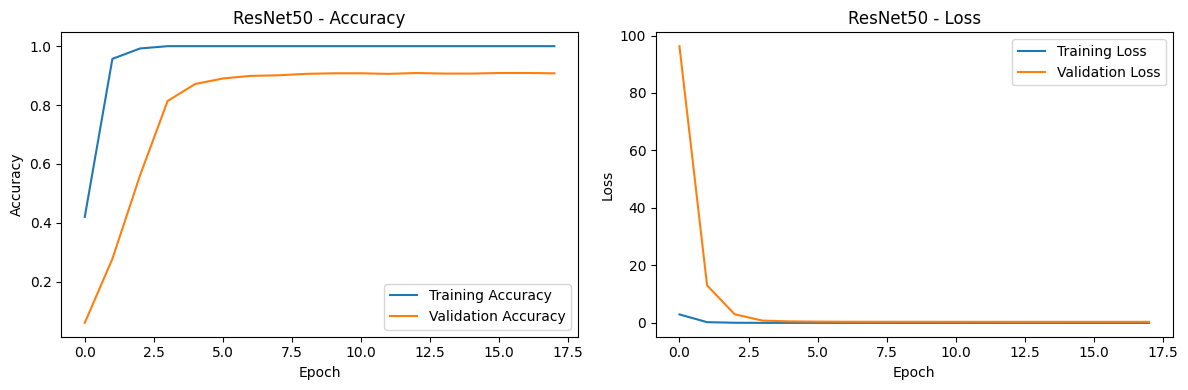

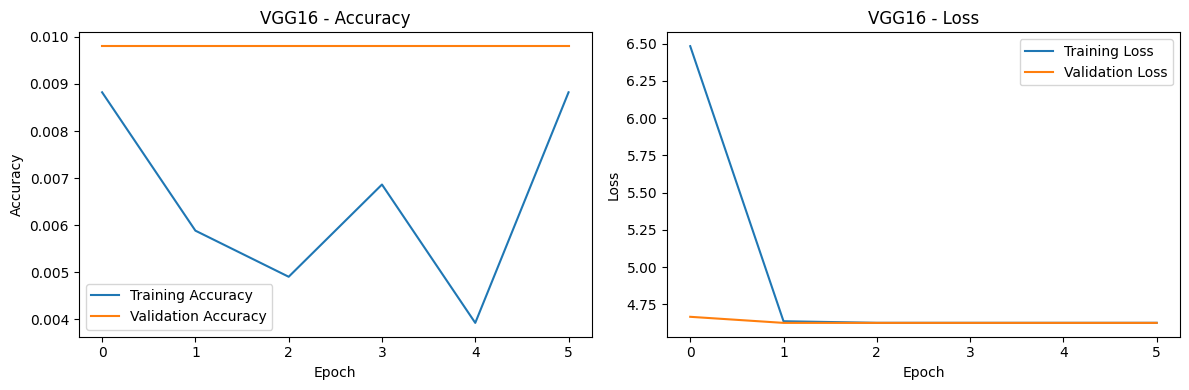

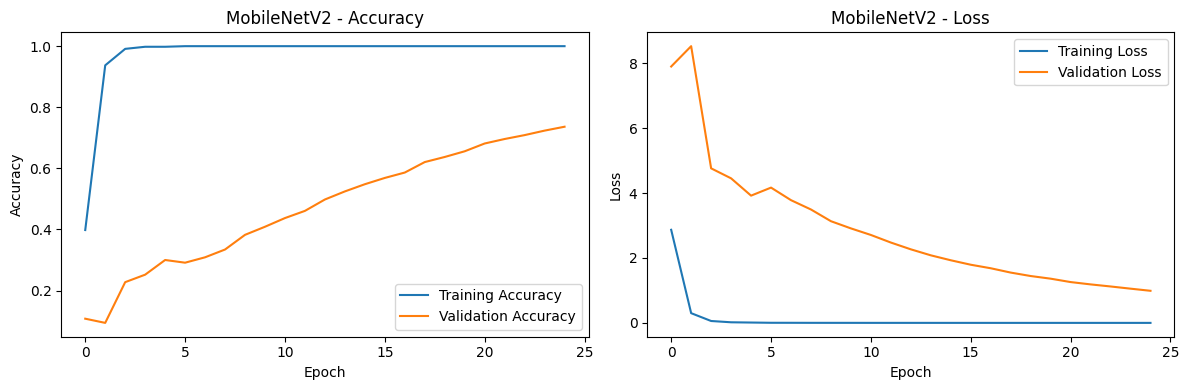

In [23]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenet, 'MobileNetV2')


## **Conclusion**

Based on my training results, the ResNet50 model was the clear winner for classifying the Oxford Flowers 102 dataset. Its validation accuracy climbed steadily to an impressive ~90%, and its loss curve showed that it learned properly without just memorizing the data.

The MobileNetV2 model, on the other hand, suffered from severe overfitting. The graphs clearly show its training accuracy shooting up to 100% while its validation accuracy got stuck around a much lower 35%. The validation loss also started to increase, confirming that the model wasn't generalizing well to new images.

The VGG16 model was the least effective, as it completely failed to learn. Its final accuracy of around 2% is no better than random guessing for a 102-class problem.

In conclusion, ResNet50 was the most successful architecture because it learned the features of the flowers and could accurately apply that knowledge to the unseen validation data.

# **Assignment Questions**

**Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?**

Based on my results, the ResNet50 model performed the best by a huge margin, achieving a final test accuracy of around 88%. The training and validation accuracy curves for ResNet50 both climbed steadily and then flattened out at high values, showing that it learned to generalize well to new images instead of just memorizing the training data.

I think this is because ResNet50's architecture, with its use of residual connections, is very powerful and well-suited for transfer learning on complex image tasks like identifying flowers. It's able to learn very deep features without losing information, which seems to have been a major advantage.













**Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100. What differences do you observe and why?**

The performance on the Flowers-102 dataset was dramatically better than on CIFAR-100, especially for ResNet50, which jumped from ~45% accuracy on CIFAR-100 to ~88% on the flowers. The biggest reason for this, I believe, is the nature of the images. The flower images are high-resolution and look much more like the real-world images from the ImageNet dataset that the models were originally trained on.

In contrast, the CIFAR-100 images are very small (32x32), and a lot of important detail is lost when they are scaled up to the 224x224 input size required by the models. Transfer learning works best when the new data is similar to the original training data, and the flower dataset was a much better fit.


**Discuss the effect of transfer learning on this dataset.**

Transfer learning was incredibly effective and was the key to the success of this project. With only about 1,000 training images, it would be nearly impossible to train a deep network like ResNet50 from scratch and achieve high accuracy. It would almost certainly overfit immediately.

By using a pre-trained model, I was able to leverage a network that already understood basic visual concepts like edges, textures, and shapes. My task was much simpler: I only had to fine-tune this existing knowledge for the specific job of telling different flowers apart. This saved a massive amount of training time and computational resources, and led to a much better result.

**Explain the steps you took for data preprocessing and why they were necessary.**

My data preprocessing pipeline had several key steps:

Loading the Data: First, I loaded the dataset using TensorFlow Datasets.

Resizing Images: I resized every image to a uniform 224x224 pixels. This was necessary because the pre-trained models I used require a fixed input size.

Applying Model-Specific Normalization: Each pre-trained model expects its pixel values to be normalized in a specific way. I created separate data pipelines for each model that applied their respective preprocess_input function. This is a critical step to ensure the input data matches what the model was originally trained on.

One-Hot Encoding Labels: I converted the integer labels (e.g., 5, 12, 98) into one-hot encoded vectors. This was necessary to use the categorical_crossentropy loss function, which is standard for multi-class classification.

Batching and Prefetching: Finally, I batched the data into groups of 32 and used .prefetch() to create an efficient pipeline. This allows the GPU to process a batch of data while the CPU prepares the next one, speeding up the training process significantly.

**Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.**

I used three well-known architectures: ResNet50, VGG16, and MobileNetV2. To adapt them for this project, I performed the following steps for each:

I loaded the model from tf.keras.applications but set include_top=False. This removed the final classification layer, which was originally designed for the 1000 classes in ImageNet.

I then added my own custom classifier head. This consisted of a GlobalAveragePooling2D layer to flatten the feature maps from the base model, followed by a new Dense layer with 102 units (one for each flower class) and a softmax activation to output the class probabilities.

I froze the layers of the pre-trained base model and then unfroze just the top few layers. This allowed the model to fine-tune its high-level feature detectors for the specific task of identifying flowers.

**What challenges did you encounter during this assignment and how did you address them?**

One major challenge was that the Oxford Flowers 102 dataset contains images of varying sizes and aspect ratios, while pre-trained CNN models require a fixed input shape. This was addressed by resizing all images to 224×224 pixels during preprocessing to ensure compatibility with ResNet50, VGG16, and MobileNetV2.

Another challenge was the need for model-specific preprocessing. Each pre-trained model expects input data to be normalized differently, and using incorrect preprocessing leads to degraded performance. This was resolved by applying the appropriate preprocessing functions from tf.keras.applications for each model.
